In [39]:
# !brew install libomp for macOS runnning only
# %pip install matplotlib seaborn
import os
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from pymongo import MongoClient
import certifi
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv # Optional: for easier local development

In [18]:
print("Starting model training...")
load_dotenv() 
MONGO_URI = os.getenv('CONNECTION_STRING')
if not MONGO_URI:
    raise ValueError("MONGO_URI environment variable not set!")

Starting model training...


In [20]:
try:
    client = MongoClient(MONGO_URI, tlsCAFile=certifi.where())
    # The ping command is a simple way to verify a successful connection
    client.admin.command('ping')
    print("✅ Successfully connected to MongoDB!")
except Exception as e:
    print(f"Error connecting to MongoDB: {e}")
    client = None # Set client to None if connection fails


✅ Successfully connected to MongoDB!


In [ ]:
# Connect to the database
# areas
# businesses
# ftpservers
# records
# users
# vehicles

In [21]:
db = client['car_parking'] 
collection = db['records'] 

In [22]:

print(f"Connecting to database '{db.name}' and collection '{collection.name}'...")
# Fetch all records and load them into a pandas DataFrame
cursor = collection.find({})
df = pd.DataFrame(list(cursor))


Connecting to database 'car_parking' and collection 'records'...


In [23]:
display(df)

,_id,areaId,datetime,plateNumber,country,confidence,angle,image,status,__v,duration
0,68831364852c779ded161aaa,687dde8379e977f9d2aaf8ef,2025-06-30 20:48:24.475,GM0885,AUS,76,8,2025-07-01_06-48-24-475_GM0885.jpg,APPROACHING,0,NaN
1,68831364852c779ded161aac,687dde8379e977f9d2aaf8ef,2025-06-30 21:56:53.630,ESN13Z,AUS,84,6,2025-07-01_07-56-53-630_ESN13Z.jpg,APPROACHING,0,NaN
2,68831364852c779ded161aab,687dde8379e977f9d2aaf8ef,2025-06-30 21:26:06.454,EBJ34E,AUS,81,9,2025-07-01_07-26-06-454_EBJ34E.jpg,APPROACHING,0,NaN
3,68831364852c779ded161aaf,687dde8379e977f9d2aaf8ef,2025-06-30 22:05:29.314,CRP89X,AUS,78,8,2025-07-01_08-05-29-314_CRP89X.jpg,APPROACHING,0,NaN
4,68831364852c779ded161ab0,687dde8379e977f9d2aaf8ef,2025-06-30 22:06:55.075,ELS64E,AUS,86,10,2025-07-01_08-06-55-075_ELS64E.jpg,APPROACHING,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4244,68a2d988d3cd8c2c267dfd4a,687dde8379e977f9d2aaf8ef,2025-08-18 07:37:36.152,CRPB9X,AUS,79,12,2025-08-18_17-37-36-152_CRPB9X.jpg,LEAVING,0,0.0
4245,68a2d988d3cd8c2c267dfd45,687dde8379e977f9d2aaf8ef,2025-08-18 07:08:56.457,ELS64E,AUS,87,18,2025-08-18_17-08-56-457_ELS64E.jpg,LEAVING,0,0.0
4246,68a2d988d3cd8c2c267dfd4d,687dde8379e977f9d2aaf8ef,2025-08-18 07:37:46.232,ESQ54G,AUS,85,10,2025-08-18_17-37-46-232_ESQ54G.jpg,LEAVING,0,0.0
4247,68a2d988d3cd8c2c267dfd4b,687dde8379e977f9d2aaf8ef,2025-08-18 07:37:37.072,CRP89X,AUS,86,11,2025-08-18_17-37-37-072_CRP89X.jpg,LEAVING,0,0.0


In [25]:
print(f"Successfully loaded {len(df)} records from MongoDB.")


Successfully loaded 4249 records from MongoDB.


In [24]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [26]:
# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Resample the data to get the count of entries for each hour
hourly_entries = df.resample('H').size().rename('entry_count')

/var/folders/04/5xm3b6sx2t37x1hynkd6cbjw0000gp/T/ipykernel_79262/3983013534.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_entries = df.resample('H').size().rename('entry_count')


In [27]:
# Assuming 'hourly_entries' is your new DataFrame
df_model = hourly_entries.to_frame()
df_model['hour'] = df_model.index.hour
df_model['day_of_week'] = df_model.index.dayofweek # Monday=0, Sunday=6
df_model['day_of_month'] = df_model.index.day
df_model['month'] = df_model.index.month

In [29]:
# Split the data at a certain point in time
split_date = '2025-08-10'
train_data = df_model.loc[df_model.index <= split_date]
test_data = df_model.loc[df_model.index > split_date]

In [30]:
# Example using an XGBoost model
import xgboost as xgb

# Define features (X) and target (y)
FEATURES = ['hour', 'day_of_week', 'day_of_month', 'month']
TARGET = 'entry_count'

# Create the model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)

# Fit the model to the training data
model.fit(train_data[FEATURES], train_data[TARGET])

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
test_predictions = model.predict(test_data[FEATURES])

In [32]:
test_data['predictions'] = test_predictions

/var/folders/04/5xm3b6sx2t37x1hynkd6cbjw0000gp/T/ipykernel_79262/2110674450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = test_predictions


Mean Absolute Error (MAE): 1.59
This means, on average, the model's prediction is off by about 1.59 vehicles per hour.
Root Mean Squared Error (RMSE): 3.26


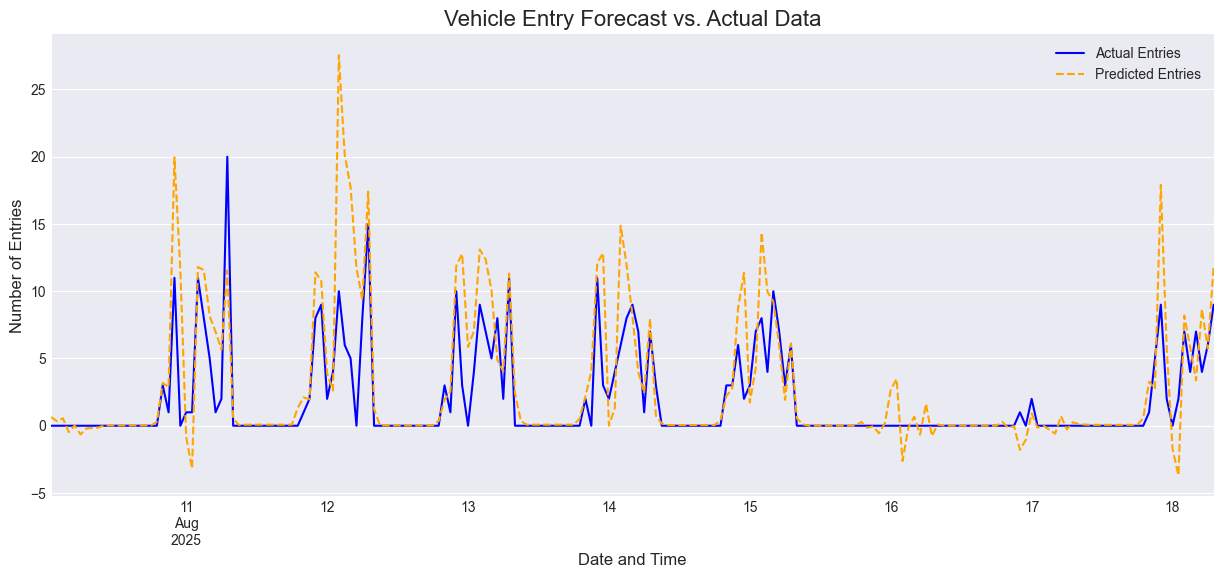

In [40]:
actuals = test_data[TARGET]
predictions = test_data['predictions']

# Mean Absolute Error (MAE) - The average absolute difference between prediction and actual
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"This means, on average, the model's prediction is off by about {mae:.2f} vehicles per hour.")

# Root Mean Squared Error (RMSE) - Punishes larger errors more heavily
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# --- Step 3: Visualize the Results ---
# Plotting the actual values vs. the predicted values is the best way to see performance.

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(15, 6))

# Plot actuals and predictions
test_data[TARGET].plot(ax=ax, label='Actual Entries', color='blue')
test_data['predictions'].plot(ax=ax, label='Predicted Entries', color='orange', linestyle='--')

# Formatting the plot
ax.set_title('Vehicle Entry Forecast vs. Actual Data', fontsize=16)
ax.set_xlabel('Date and Time', fontsize=12)
ax.set_ylabel('Number of Entries', fontsize=12)
ax.legend()
plt.show()

In [41]:
# For XGBoost
model.save_model("vehicle_forecaster.json")

# For scikit-learn or other models using joblib
import joblib
joblib.dump(model, "vehicle_forecaster.joblib")

['vehicle_forecaster.joblib']